In [ ]:
"""
An example of variational autoencoder implementation using MNIST data

VAE can be considered a self-learner model as they map data features into the 
latent space which are probabilistically modelled. Sampling distribution allows
to get new points which makes VAE a generative model. There are a lot of 
advantages of defining latent variables using probabilistic modelling which 
improves the model's ability to generalise.

It is important to point out that AEs and VAEs are lossy when used for data 
compression and also can only work on the data that it was trained to encode 
and decode.

This example will demonstrate the basics of creating VAE.

"""

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist

from keras import layers
from keras import backend as K

In [28]:
#Set params
EPOCHS=100
BATCH=256
VAL_SPLIT=0.2

#define VAE parameters
input_dim=28*28
l_dim=2 #latent dimensions for z_mean and z_log_sigma to create a sampling model

In [4]:
#Load data

(X_train,y_train),(X_test,y_test)=mnist.load_data()

#Prepare data
X_train=X_train.astype('float32')/255.0
X_test=X_test.astype('float32')/255.0

X_train=X_train.reshape(-1,28*28)
X_test=X_test.reshape(-1,28*28)
print(X_train.shape)
print(y_train[1:10])

11501568/11490434 [==============================] - 0s 0us/step
(60000, 784)
[0 4 1 9 2 1 3 1 4]


In [ ]:
"""
We are splitting our model into 3 models:

1. Encoder to capture features and map them into the latent space
2. Decoder that uses a generator to sample points from the latent space and
   reconstruct samples.
3. VAE model taking samples and mapping their reconstructions.
"""

In [50]:
#Define encoder layers
input=keras.Input(shape=(input_dim,))
h=layers.Dense(128,activation='relu',activity_regularizer=keras.regularizers.l1(10e-6))(input)
#h=layers.Dense(64,activation='relu',activity_regularizer=keras.regularizers.l1(10e-6))(h)
#h=layers.Dense(32,activation='relu',activity_regularizer=keras.regularizers.l1(10e-6))(h)

z_mean=layers.Dense(l_dim)(h)
z_log_sigma=layers.Dense(l_dim)(h)

In [51]:
#Create a sampling function for the latent layer

def sample(vals):
  #Sampling function from the latent space
  z_mean,z_log_sigma=vals
  epsilon=K.random_normal(shape=(K.shape(z_mean)[0],l_dim),mean=0.0,stddev=0.1)
  return z_mean+K.exp(z_log_sigma)*epsilon

#Create a sampling layers using Lambda
z=layers.Lambda(sample)([z_mean,z_log_sigma])

In [52]:
#Define encoder

encoder=keras.Model(input,[z_mean,z_log_sigma,z], name='encoder')

#Define decoder
latent_input=keras.Input(shape=(l_dim,),name='latent_sampling')
h=layers.Dense(32,activation='relu')(latent_input)
h=layers.Dense(64,activation='relu')(h)
h=layers.Dense(128,activation='relu')(h)
decoder_output=layers.Dense(input_dim,activation='sigmoid')(h)

decoder=keras.Model(latent_input,decoder_output,name='decoder')

#Create VAE
output=decoder(encoder(input)[2]) #we want z output
vae=keras.Model(input,output,name='vae')

In [53]:
print(vae.summary())

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               100996    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               111664    
                                                                 
Total params: 212,660
Trainable params: 212,660
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
#Define a custom loss function for VAE

reconstruction_loss=keras.losses.binary_crossentropy(input,output)*input_dim #main loss function per pixel
KL_loss=1+z_log_sigma-K.square(z_mean)-K.exp(z_log_sigma) #KL divergence as a regulirarization term
KL_loss=K.sum(KL_loss,axis=1)*-0.5
VAE_loss=K.mean(reconstruction_loss+KL_loss)
#add loss to the model
vae.add_loss(VAE_loss)
#Compile model
vae.compile(optimizer='adam')

Epoch 1/100
188/188 [==============================] - 2s 7ms/step - loss: 235.3292 - val_loss: 183.8188
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 174.6447 - val_loss: 168.1832
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 165.7507 - val_loss: 163.1796
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 162.5070 - val_loss: 161.2171
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 160.6774 - val_loss: 159.5070
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 159.1167 - val_loss: 158.1582
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 157.6622 - val_loss: 156.7881
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 156.3184 - val_loss: 155.7481
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 155.1212 - val_loss: 154.7276
Epoch 10/100
188/188 [==============================] -

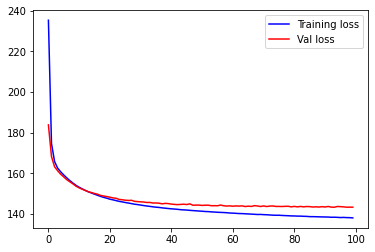

In [55]:
history=vae.fit(X_train,X_train,epochs=EPOCHS,batch_size=BATCH,validation_split=0.2)

epochs=history.epoch
history=history.history
print("best epoch",epochs[np.argmin(history['val_loss'])])

plt.plot(epochs,history['loss'],'-b',label='Training loss')
plt.plot(epochs,history['val_loss'],'-r',label='Val loss')
plt.legend()
plt.show()


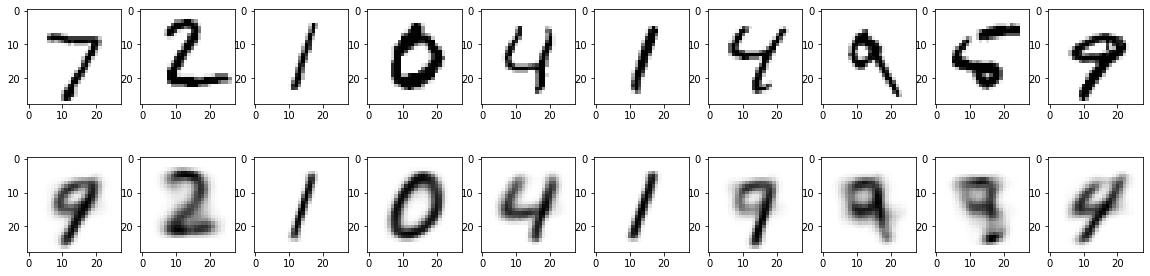

In [57]:
vae_images=vae.predict(X_test)
#Inspect autoencoder images
fig,ax=plt.subplots(2,10,figsize=(20,5))
for i in range(10): 
  #Visualise the encoded images
  ax[0,i].imshow(X_test[i].reshape(28,28),cmap='binary') 
  ax[1,i].imshow(vae_images[i].reshape(28,28),cmap='binary')

plt.show()

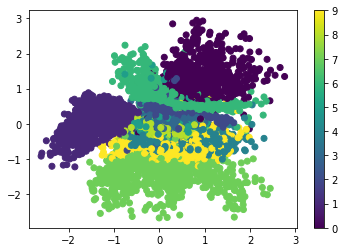

In [48]:
#We can see that the VAE mixes some images, we can explore the lattent space and 
#how similar images distribute using the encoder and it's outputs

#Visualise the latent space
X_test_encoded=encoder.predict(X_test)[0]

plt.scatter(X_test_encoded[:,0],X_test_encoded[:,1],c=y_test)
plt.colorbar()
plt.show()

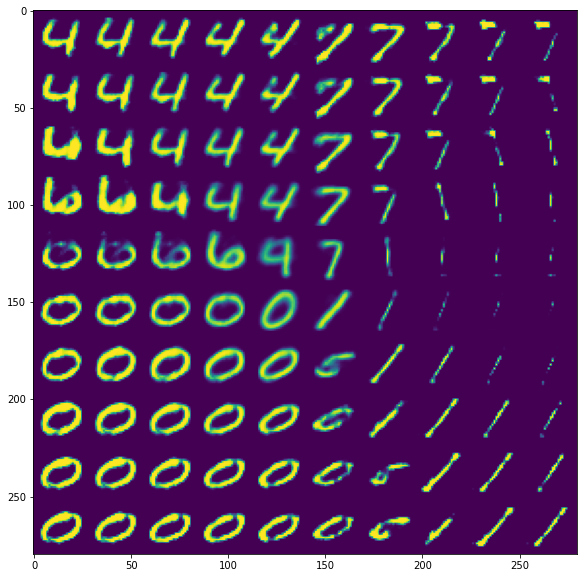

In [58]:
#Use generative properties of the decoder to sample new numbers

img_size=28
n=10 #number of digits to sample

#Create a larger matrix to capture all images
fig=np.zeros((n*img_size,n*img_size))

#Define sampling space
x=np.linspace(-10,10,n)
y=np.linspace(-10,10,n)

for i,xi in enumerate(x):
  for j,yj in enumerate(y):

    z_sample=np.array([[xi,yj]]) #get sample parameters for z_mean and z_log_sigma
    decoded_sample=decoder.predict(z_sample) #decode the sample
    #Add the decoded sample to fig
    img=decoded_sample[0].reshape(img_size,img_size) 
    fig[i*img_size:(i+1)*img_size,j*img_size:(j+1)*img_size]=img

#Plot sampled digits
plt.figure(figsize=(10,10))
plt.imshow(fig)
plt.show()

In [73]:
"""
Compare the results with convolutional layer
"""

#Load data

(X_train,y_train),(X_test,y_test)=mnist.load_data()

#Prepare data
X_train=X_train.astype('float32')/255.0
X_train=X_train.reshape(-1,28,28,1)
X_test=X_test.astype('float32')/255.0
X_test=X_test.reshape(-1,28,28,1)

#Add noise to the data
noise=0.5
X_train_noise=X_train+noise*np.random.normal(loc=0.0,scale=1.0,size=X_train.shape)
X_train_noise=np.clip(X_train_noise,0.0,1.0) #ensure that the range remains within the scaled interval
X_test_noise=X_test+noise*np.random.normal(loc=0.0,scale=1.0,size=X_test.shape)
X_test_noise=np.clip(X_test_noise,0.0,1.0)

print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [107]:

#Define encoder layers
input_shape=(28,28,1)
input=keras.Input(shape=input_shape)


h=layers.Conv2D(64,(3,3),activation='relu',padding='same')(input)
h=layers.MaxPool2D((2,2),padding='same')(h)
h=layers.Conv2D(32,(3,3),activation='relu',padding='same')(h)
h=layers.Conv2D(64,(3,3),activation='relu',padding='same')(h)
h=layers.MaxPool2D((2,2),padding='same')(h)
h=layers.Conv2D(16,(3,3),activation='relu',padding='same')(h)
h_dim=K.int_shape(h)
h=layers.GlobalAveragePooling2D()(h)

h=layers.Dense(16,activation='relu')(h)
z_mean=layers.Dense(l_dim)(h)
z_log_sigma=layers.Dense(l_dim)(h)

#Create a sampling function for the latent layer

def sample(vals):
  #Sampling function from the latent space
  z_mean,z_log_sigma=vals
  epsilon=K.random_normal(shape=(K.shape(z_mean)[0],l_dim),mean=0.0,stddev=0.1)
  return z_mean+K.exp(z_log_sigma)*epsilon

#Create a sampling layers using Lambda
z=layers.Lambda(sample)([z_mean,z_log_sigma])

#Define encoder

encoder=keras.Model(input,[z_mean,z_log_sigma,z], name='encoder')

print(encoder.summary())


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_75 (Conv2D)             (None, 28, 28, 64)   640         ['input_19[0][0]']               
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 14, 14, 64)  0           ['conv2d_75[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 14, 14, 32)   18464       ['max_pooling2d_16[0][0]'] 

In [113]:

#Define decoder
latent_input=keras.Input(shape=(l_dim,),name='latent_sampling')

#Global average pooling reversal
h=layers.Dense(np.prod(h_dim[1:]),activation='relu')(latent_input)

h=layers.Reshape(h_dim[1:])(h) 

h=layers.Conv2D(16,(3,3),padding='same',activation='relu')(h)
h=layers.UpSampling2D((2,2))(h)
h=layers.Conv2D(32,(3,3),padding='same',activation='relu')(h)
h=layers.UpSampling2D((2,2))(h)
#h=layers.Conv2D(64,(3,3),padding='valid',activation='relu')(h)
#h=layers.UpSampling2D((2,2))(h)

decoded_output=layers.Conv2D(1,(3,3),padding='same',activation='sigmoid')(h)

decoder=keras.Model(latent_input,decoded_output,name='decoder')

print(decoder.summary())



Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latent_sampling (InputLayer  [(None, 2)]              0         
 )                                                               
                                                                 
 dense_86 (Dense)            (None, 784)               2352      
                                                                 
 reshape_19 (Reshape)        (None, 7, 7, 16)          0         
                                                                 
 conv2d_98 (Conv2D)          (None, 7, 7, 16)          2320      
                                                                 
 up_sampling2d_46 (UpSamplin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_99 (Conv2D)          (None, 14, 14, 32)        4640

In [114]:
#Create VAE
output=decoder(encoder(input)[2]) #we want z output
vae=keras.Model(input,output,name='vae')

print(vae.summary())

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               47172     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         9601      
                                                                 
Total params: 56,773
Trainable params: 56,773
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/100
188/188 [==============================] - 7s 30ms/step - loss: 218630.8281 - val_loss: 219491.2031
Epoch 2/100
188/188 [==============================] - 5s 28ms/step - loss: 217758.4688 - val_loss: 219927.9844
Epoch 3/100
188/188 [==============================] - 5s 28ms/step - loss: 217593.6406 - val_loss: 219097.2344
Epoch 4/100
188/188 [==============================] - 5s 28ms/step - loss: 217425.6562 - val_loss: 218925.7188
Epoch 5/100
188/188 [==============================] - 5s 28ms/step - loss: 217603.4844 - val_loss: 219898.7656
Epoch 6/100
188/188 [==============================] - 5s 28ms/step - loss: 217440.1562 - val_loss: 219548.3125
Epoch 7/100
188/188 [==============================] - 5s 29ms/step - loss: 217212.0469 - val_loss: 219318.9531
Epoch 8/100
188/188 [==============================] - 5s 29ms/step - loss: 217277.7188 - val_loss: 220172.9062
Epoch 9/100
188/188 [==============================] - 5s 29ms/step - loss: 217302.0938 - val_loss: 2186

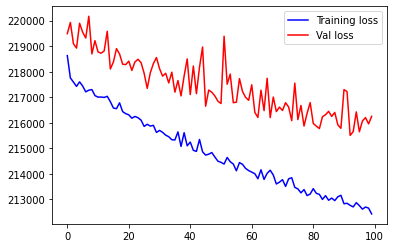

In [117]:

#Define a custom loss function for VAE

reconstruction_loss=keras.losses.binary_crossentropy(K.flatten(input),K.flatten(output))*input_dim*input_dim #main loss function per pixel
KL_loss=1+z_log_sigma-K.square(z_mean)-K.exp(z_log_sigma) #KL divergence as a regulirarization term
KL_loss=K.sum(KL_loss,axis=-1)*-0.5
VAE_loss=K.mean(reconstruction_loss+KL_loss)

#add loss to the model
vae.add_loss(VAE_loss)
#Compile model
vae.compile(loss='binary_crossentropy',optimizer='adam')

history=vae.fit(X_train,X_train,epochs=EPOCHS,batch_size=BATCH,validation_split=0.2, shuffle=True)

epochs=history.epoch
history=history.history
print("best epoch",epochs[np.argmin(history['val_loss'])])

plt.plot(epochs,history['loss'],'-b',label='Training loss')
plt.plot(epochs,history['val_loss'],'-r',label='Val loss')
plt.legend()
plt.show()


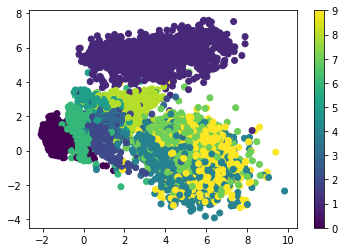

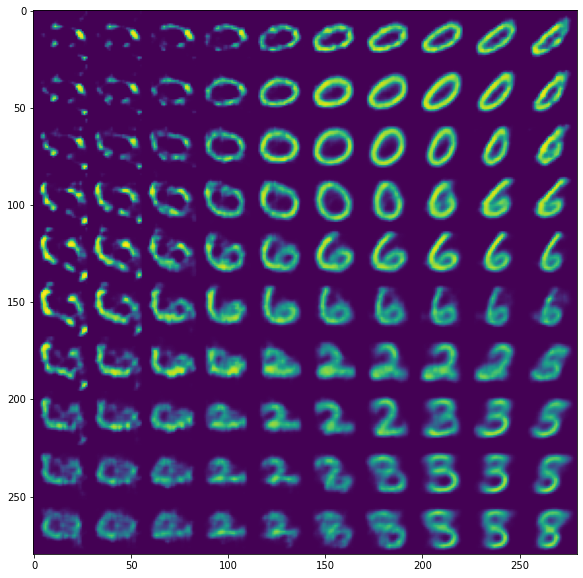

In [119]:

#We can see that the VAE mixes some images, we can explore the lattent space and 
#how similar images distribute using the encoder and it's outputs

#Visualise the latent space
X_test_encoded=encoder.predict(X_test)[0]

plt.scatter(X_test_encoded[:,0],X_test_encoded[:,1],c=y_test)
plt.colorbar()
plt.show()

#Use generative properties of the decoder to sample new numbers

img_size=28
n=10 #number of digits to sample

#Create a larger matrix to capture all images
fig=np.zeros((n*img_size,n*img_size))

#Define sampling space which can be based on how the latent space images obverlap
x=np.linspace(-2,2,n)
y=np.linspace(-2,2,n)

for i,xi in enumerate(x):
  for j,yj in enumerate(y):

    z_sample=np.array([[xi,yj]]) #get sample parameters for z_mean and z_log_sigma
    decoded_sample=decoder.predict(z_sample) #decode the sample
    #Add the decoded sample to fig
    img=decoded_sample[0].reshape(img_size,img_size) 
    fig[i*img_size:(i+1)*img_size,j*img_size:(j+1)*img_size]=img

#Plot sampled digits
plt.figure(figsize=(10,10))
plt.imshow(fig)
plt.show()